In [1]:
# standard library dependencies
from collections import Counter

# external dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

# local dependencies
from classification_preparation import (
    load_dataset_with_engineered_features,
    return_data_to_predict_at_month,
    prepare_to_predict_feature,
    split_into_training_validating_testing
)

from compute_deltas_df import get_deltas_df

from ensemble_classifiers import (
    GB_classifier,
    RF_classifier,
    NB_classifier
)

from create_violin_plots import create_violin_plots_model_acc

In [2]:
all_data = load_dataset_with_engineered_features(
    "data",
    must_have_substring="cleaned_",
    verbose=True
)

datasets_before_test_dataset = [
    "cleaned_01-2018.txt",
    "cleaned_02-2018.txt",
    "cleaned_03-2018.txt",
    "cleaned_04-2018.txt",
    "cleaned_05-2018.txt",
    "cleaned_06-2018.txt",
    "cleaned_07-2018.txt",
    "cleaned_08-2018.txt",
    "cleaned_09-2018.txt",
    "cleaned_10-2018.txt",
    "cleaned_11-2018.txt",
    "cleaned_12-2018.txt",
    "cleaned_01-2019.txt",
    "cleaned_02-2019.txt",
    "cleaned_2019-03.txt",
    "cleaned_2019-04.txt",
    "cleaned_2019-05.txt",
    "cleaned_2019-06.txt",
    "cleaned_2019-07.txt",
    "cleaned_2019-08.txt"
]

datasets_for_delta = [
    "cleaned_01-2019.txt",
    "cleaned_02-2019.txt",
    "cleaned_2019-03.txt",
    "cleaned_2019-04.txt",
    "cleaned_2019-05.txt",
    "cleaned_2019-06.txt",
    "cleaned_2019-07.txt",
    "cleaned_2019-08.txt"
]


cleaned_01-2018.txt: (6493, 26)

cleaned_01-2019.txt: (9707, 26)

cleaned_02-2018.txt: (6733, 26)

cleaned_02-2019.txt: (9923, 26)

cleaned_03-2018.txt: (7015, 26)

cleaned_04-2018.txt: (7328, 26)

cleaned_05-2018.txt: (7678, 26)

cleaned_06-2018.txt: (7944, 26)

cleaned_07-2018.txt: (8209, 26)

cleaned_08-2018.txt: (8443, 26)

cleaned_09-2018.txt: (8652, 26)

cleaned_10-2018.txt: (8940, 26)

cleaned_11-2018.txt: (9218, 26)

cleaned_12-2018.txt: (9440, 26)

cleaned_2019-03.txt: (10171, 26)

cleaned_2019-04.txt: (10518, 26)

cleaned_2019-05.txt: (10829, 26)

cleaned_2019-06.txt: (11124, 26)

cleaned_2019-07.txt: (11388, 26)

cleaned_2019-08.txt: (11668, 26)

cleaned_2019-09.txt: (11986, 26)

finished compiling 21 datasets
loaded 21 datasets; adding engineered features
added engineered features to all datasets


In [3]:
print(all_data["cleaned_2019-09.txt"].tail())

               DR Speciality  Payment Method #5  Payment Method #4  \
Patient ID                                                           
Patient_12146            0.0                0.0                0.0   
Patient_12147            0.0                1.0                0.0   
Patient_12148            0.0                0.0                0.0   
Patient_12149            0.0                0.0                0.0   
Patient_12150            0.0                0.0                0.0   

               DR PROVINCE  Dosage  DR ID  Payment Method #1  Status Group  \
Patient ID                                                                   
Patient_12146          0.0     0.0    0.0                0.0           0.0   
Patient_12147          4.0     0.0  835.0                0.0           3.0   
Patient_12148          4.0     0.0  429.0                0.0           2.0   
Patient_12149          0.0     0.0    0.0                0.0           0.0   
Patient_12150          0.0     0.0    0.0

In [4]:
useable_data = return_data_to_predict_at_month(
    all_data,
    "cleaned_2019-08.txt",
    verbose=True
)

100%|████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.53it/s]


11388 useable patients


In [5]:
useable_data.columns

Index(['delta_DR Speciality', 'delta_Payment Method #5',
       'delta_Payment Method #4', 'delta_DR PROVINCE', 'delta_Dosage',
       'delta_DR ID', 'delta_Payment Method #1', 'delta_Status Group',
       'delta_Status Description', 'delta_Frequency', 'delta_Diagnosis ID',
       'delta_Payment Method #3', 'delta_Biologic Line of Therapy',
       'delta_Status', 'delta_Gender ID', 'delta_Payment Method #2',
       'delta_Patient Receiving Free Drug', 'delta_Case State',
       'delta_Age Range', 'delta_Day Enrollment Received',
       'delta_Day Enrollment Completed', 'delta_State Change Day',
       'delta_On Drug Start Day', 'delta_Last On Drug Day',
       'delta_Re-Engagement Day', 'delta_Re-Engagement On Drug Start Day',
       'delta_Enrollment Time', 'delta_On Drug Time',
       'delta_# of Payment Methods', 'delta_DosageFrequencyIndex',
       'delta_Number of Months', 'DR Speciality', 'Payment Method #5',
       'Payment Method #4', 'DR PROVINCE', 'Dosage', 'DR ID',
       'P

In [6]:
delta_columns = [ colname for colname in useable_data.columns 
                 if "delta_" in colname]

useable_data = useable_data.drop(columns=delta_columns)

In [7]:
deltas_for_month = get_deltas_df(
    datasets_for_delta,
    all_data
)

same_patients = list( set(deltas_for_month.index.tolist()).intersection( set(useable_data.index.tolist()) ) )

useable_data = useable_data.loc[same_patients,:]

useable_data = pd.concat([useable_data, deltas_for_month.loc[same_patients,"delta_DosageFrequencyIndex"]], axis=1)

useable_data["delta_DosageFrequencyIndex"] = useable_data["delta_DosageFrequencyIndex"].astype(bool).astype(int)
#print(useable_data.columns)
#print(set(useable_data.loc[:,"delta_Patient Receiving Free Drug"].values.tolist()))
print(useable_data["delta_DosageFrequencyIndex"].values.tolist())

100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.39it/s]


[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
deltas_for_month.head()

,delta_DR Speciality,delta_Payment Method #5,delta_Payment Method #4,delta_DR PROVINCE,delta_Dosage,delta_DR ID,delta_Payment Method #1,delta_Status Group,delta_Status Description,delta_Frequency,...,delta_State Change Day,delta_On Drug Start Day,delta_Last On Drug Day,delta_Re-Engagement Day,delta_Re-Engagement On Drug Start Day,delta_Enrollment Time,delta_On Drug Time,delta_# of Payment Methods,delta_DosageFrequencyIndex,delta_Number of Months
Patient_165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
Patient_166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
Patient_167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
Patient_168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
Patient_169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [9]:
features_df, feature_to_predict = prepare_to_predict_feature(
    "delta_DosageFrequencyIndex",
    useable_data,
    verbose=True
)
labels = list(set(feature_to_predict.values.tolist()))

In [10]:
all_splits_dict = split_into_training_validating_testing(
    features_df,
    feature_to_predict,
    verbose=True
)

# keys of dictionaries in all_splits_dict
#"X train",
#"X validate", 
#"X test", 
#"y train", 
#"y validate", 
#"y test"

dimensions of testing dataset: (1709, 30), (1709,)
dimensions of validating dataset: (1936, 30), (1936,)
dimensions of training dataset: (7743, 30), (7743,)
dimensions of original dataset: (11388, 30)


In [11]:
for splits_dict in all_splits_dict:
    # result is a dict of:
    # "Model Confusion Matrix"
    # "Model Accuracy"
    # "Baseline Confusion Matrix"
    # "Baseline Accuracy"
    # "Classifier"
    result = RF_classifier(
        splits_dict["X train"],
        splits_dict["y train"],
        splits_dict["X test"],
        splits_dict["y test"],
        labels,
        return_baseline_cm = True
    )


In [12]:
print(result["Model Accuracy"], result["Baseline Accuracy"])
print("\n")
print(result["Model Confusion Matrix"])
print("\n")
print(result["Baseline Confusion Matrix"])

0.9210064365125804 0.8297249853715624


[[1540    6]
 [ 129   34]]


[[1403  143]
 [ 148   15]]


In [13]:
all_splits_dict = split_into_training_validating_testing(
    features_df,
    feature_to_predict,
    verbose=True,
    use_strat_splits=True
)

# keys of dictionaries in all_splits_dict
#"X train",
#"X validate", 
#"X test", 
#"y train", 
#"y validate", 
#"y test"

In [14]:
num_classes = len(np.unique(feature_to_predict))
RF_model_accs, RF_model_cm = [], np.zeros((num_classes,num_classes))
GB_model_accs, GB_model_cm = [], np.zeros((num_classes,num_classes))
NB_model_accs, NB_model_cm = [], np.zeros((num_classes,num_classes))
baseline_accs = []
baseline_model_cm = np.zeros((num_classes,num_classes))

RF_outcomes = pd.DataFrame(np.zeros((10,2)), columns=["Model Acc", "Baseline Acc"])
GB_outcomes = pd.DataFrame(np.zeros((10,2)), columns=["Model Acc", "Baseline Acc"])
NB_outcomes = pd.DataFrame(np.zeros((10,2)), columns=["Model Acc", "Baseline Acc"])


for model, acc_list, avg_cm, name, df in zip(
    [RF_classifier, GB_classifier, NB_classifier],
    [RF_model_accs, GB_model_accs, NB_model_accs],
    [RF_model_cm, GB_model_cm, NB_model_cm],
    ["RF","GB","NB"],
    [RF_outcomes, GB_outcomes, NB_outcomes]):
    print(f"========{name}========")
    for e, splits_dict in enumerate(all_splits_dict):
        # result is a dict of:
        # "Model Confusion Matrix"
        # "Model Accuracy"
        # "Baseline Confusion Matrix"
        # "Baseline Accuracy"
        # "Classifier"
        result = model(
            splits_dict["X train"],
            splits_dict["y train"],
            splits_dict["X test"],
            splits_dict["y test"],
            labels,
            return_baseline_cm = True
        )
        print( result["Model Accuracy"], result["Baseline Accuracy"] )
        acc_list.append( result["Model Accuracy"] )
        acc_list.append( result["Baseline Accuracy"] )
        df.loc[e, "Model Acc"] = result["Model Accuracy"]
        df.loc[e, "Baseline Acc"] = result["Baseline Accuracy"]
        #if e == 0:
        #    avg_cm = (result["Model Confusion Matrix"] / 10)
        #else:
            #pass
        avg_cm += (result["Model Confusion Matrix"] / 10)

        #if baseline_model_cm is None:
        #    baseline_model_cm = (result["Baseline Confusion Matrix"] / 30)
        #else: 
            #pass
        baseline_accs.append(result["Baseline Accuracy"])
        baseline_model_cm += (result["Baseline Confusion Matrix"] / 30)
    print(avg_cm)

========RF========
0.9221767115272089 0.8221181977764774
0.919836161497952 0.8326506729081334
0.9221767115272089 0.8326506729081334
0.9221767115272089 0.8197776477472206
0.9221767115272089 0.8285547103569338
0.9210064365125804 0.8385020479812756
0.9215915740198947 0.8168519602106495
0.9221767115272089 0.8115857226448215
0.9221767115272089 0.8191925102399064
0.9215915740198947 0.8320655354008192
[[1541.8    4.2]
 [ 129.6   33.4]]
========GB========
0.952018724400234 0.8285547103569338
0.9496781743709772 0.8373317729666472
0.9479227618490346 0.8320655354008192
0.938560561732007 0.81275599765945
0.9514335868929198 0.8297249853715624
0.9414862492685782 0.8279695728496197
0.9479227618490346 0.8203627852545348
0.9496781743709772 0.8297249853715624
0.9485078993563487 0.826214160327677
0.9409011117612639 0.8191925102399064
[[1523.2   22.8]
 [  68.1   94.9]]
========NB========
0.9052077238150965 0.826214160327677
0.9057928613224108 0.8385020479812756
0.9052077238150965 0.8168519602106495
0.9052

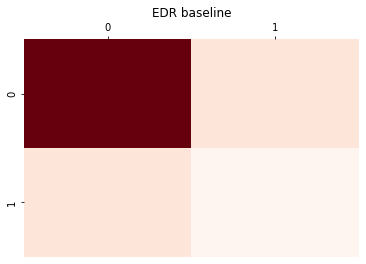

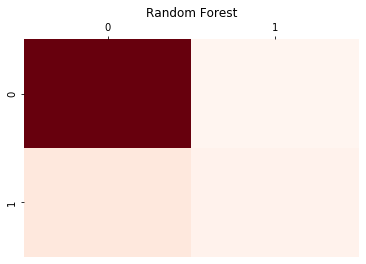

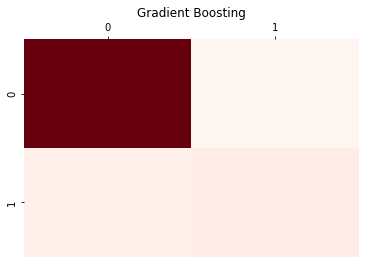

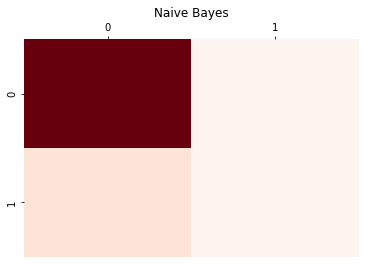

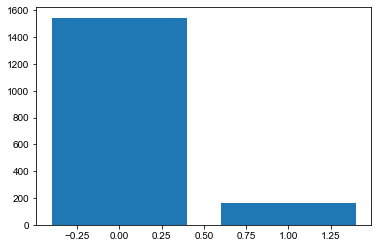

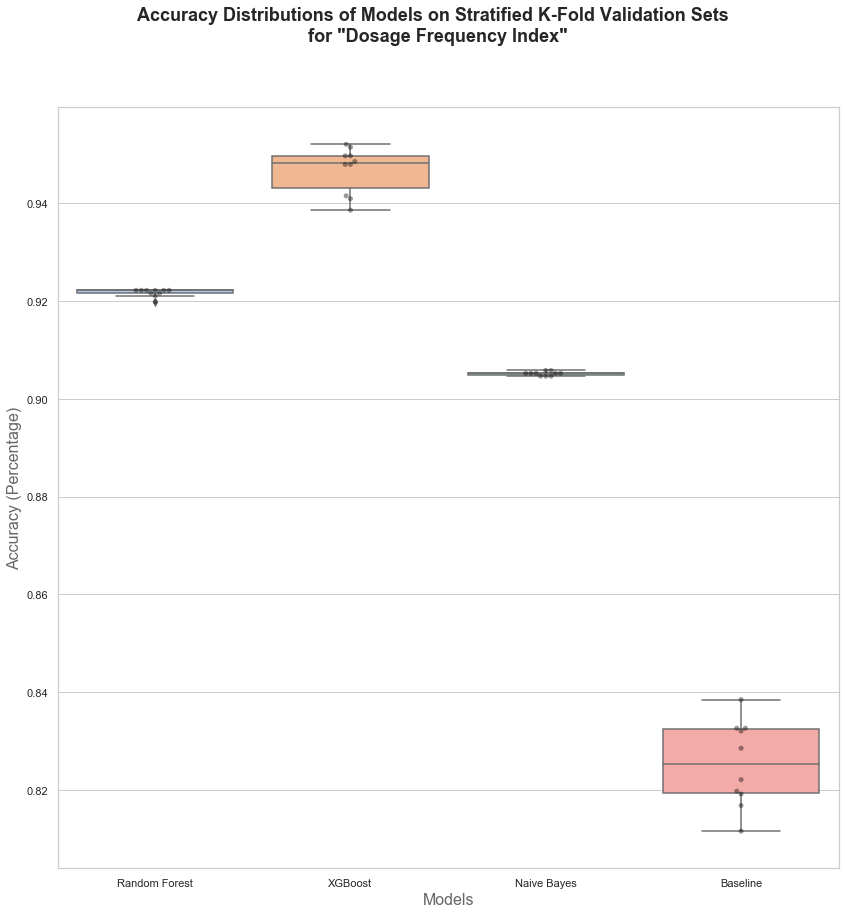

In [15]:
for e, (cm, name) in enumerate(
    zip([baseline_model_cm, RF_model_cm, GB_model_cm, NB_model_cm], 
        ["EDR baseline", "Random Forest", "Gradient Boosting", "Naive Bayes"])):
    cm_norm = cm / cm.sum()
    ax = sns.heatmap(cm_norm, cmap="Reds", cbar=False)
    ax.xaxis.set_ticks_position('top')
    ax.set_title(name)
    plt.show()

plt.bar(x=np.arange(cm.shape[0]), height=cm.sum(axis=1))

create_violin_plots_model_acc(RF_outcomes.values, GB_outcomes.values, NB_outcomes.values, baseline_accs)